## Binary Classification using TensorFlow and Apache MxNet Neural Network (NN)



#### This example is modified version of:
#### https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/

# Customer Churn Prediction with Neural Network


## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_

Losing customers is costly for any business.  Identifying unhappy customers early on gives you a chance to offer them incentives to stay.  This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us–leaving a mobile phone operator.  Seems like I can always find fault with my provider du jour! And if my provider knows that I’m thinking of leaving, it can offer timely incentives–I can always use a phone upgrade or perhaps have a new feature activated–and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.


In [3]:
# https://keras.io/
# https://github.com/keras-team/keras/issues/2743
# Change Kernel to use Tensor Flow. For example: conda_tensorflow_p36
import sys
import numpy as np
# Set random seed
np.random.seed(0)

import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import classification_report, confusion_matrix

# Column Transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, KBinsDiscretizer
# from tensorflow import keras
# Keras Library
from keras.models import Sequential
from keras.layers import Dense, Activation

---
## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.  Let's download and read that dataset in now:

In [4]:
ls

 Volume in drive C is OSDisk
 Volume Serial Number is E47C-3FFA

 Directory of C:\WORK\Projects\AWS_sagemker\CustomerChurn

07/26/2022  06:08 PM    <DIR>          .
07/26/2022  06:08 PM    <DIR>          ..
07/26/2022  01:29 PM    <DIR>          .ipynb_checkpoints
07/26/2022  03:42 PM         1,213,387 customer_churn_data_preparation_onehotencoded.ipynb
07/26/2022  06:08 PM            33,391 customer_churn_neural_network.ipynb
               2 File(s)      1,246,778 bytes
               3 Dir(s)  214,545,424,384 bytes free


In [5]:
train_file = '../data/churn/train_onehot.csv'
validation_file = '../data/churn/validation_onehot.csv'
test_file = '../data/churn/test_onehot.csv'

In [6]:
# Specify the column names as the file does not have column header
df_train = pd.read_csv(train_file, header=None)
df_validation = pd.read_csv(validation_file, header=None)
df_test = pd.read_csv(test_file, header=None)

In [7]:
df_train.shape

(3500, 100)

In [8]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.267619,-0.379309,-0.298942,1.006400,-0.847559,-2.405590,0.773025,1.093840,-0.253296,2.192150
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.827386,-0.698066,0.885926,-0.811460,2.716280,0.406491,-0.768708,0.118558,-0.253296,-1.727480
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.267619,-1.181980,0.885926,-0.709372,1.132350,0.016037,0.259114,1.471740,-0.253296,-0.257617
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.097382,1.313130,0.293492,0.836222,-0.847559,-0.303330,-1.282620,-0.897845,0.279510,0.232336
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.827386,-0.113885,-0.891377,-1.559140,-0.451578,0.324540,-0.768708,2.222620,-0.253296,0.722288


In [9]:
df_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.632621,-1.495140,-0.891377,-0.397260,-1.243540,-0.156640,0.259114,-1.301300,-2.384520,2.682100
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.827386,0.866517,-0.891377,1.000300,-0.847559,-1.203840,0.259114,-0.536697,1.877930,0.232336
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.267619,1.625260,-0.891377,0.830239,-0.847559,0.080766,-1.796530,0.795608,0.812315,-0.747570
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.827386,-0.024542,-0.298942,1.648560,1.132350,0.166621,-0.254797,1.320260,-1.851710,-0.747570
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.632621,1.222310,-0.298942,1.047360,-1.243540,-0.024567,-0.768708,2.003520,0.812315,-0.747570


In [10]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.827386,-0.130086,0.885926,0.737241,-0.451578,-0.286611,0.773025,-0.618697,0.812315,0.232336
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.827386,2.040540,-0.891377,0.287210,0.736368,0.574123,-0.768708,0.839787,-0.253296,-1.237520
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.827386,-1.361700,-0.298942,-1.722720,-1.243540,0.459187,1.286940,-0.629641,1.345120,0.722288
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.827386,-1.146950,2.663230,1.101210,1.528330,-1.876940,0.773025,1.876660,-1.851710,-0.747570
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.632621,-0.082698,-1.483810,-1.058810,-1.243540,-0.446285,-0.768708,-2.701940,-0.253296,1.702190


In [11]:
X_train = df_train.iloc[:,1:] # Features: 1st column onwards 
y_train = df_train.iloc[:,0].ravel() # Target: 0th column

X_validation = df_validation.iloc[:,1:] # Features: 1st column onwards 
y_validation = df_validation.iloc[:,0].ravel() # Target: 0th column

X_test = df_test.iloc[:,1:] # Features: 1st column onwards 
y_test = df_test.iloc[:,0].ravel() # Target: 0th column

## Build Model using Keras  
Reference: https://keras.io/getting-started/sequential-model-guide/  

In [12]:
# https://keras.io/getting-started/sequential-model-guide/
model = Sequential()
# 1 hidden layer with 30 neurons with relu activation
# output layer - binaryclassification, so use sigmoid activation
# optimizer - use adam or rmsprop
# loss function - logistic loss function - called as binary cross entropy in keras
# metrics - additional metrics to report
model.add(Dense(30, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
from keras.callbacks import EarlyStopping

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [15]:
# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
         validation_data=(X_validation,y_validation),callbacks=[early_stopping])

Epoch 1/20
110/110 [==============================] - 2s 6ms/step - loss: 0.5848 - accuracy: 0.7337 - val_loss: 0.4467 - val_accuracy: 0.8420
Epoch 2/20
110/110 [==============================] - 1s 5ms/step - loss: 0.3722 - accuracy: 0.8577 - val_loss: 0.3188 - val_accuracy: 0.8690
Epoch 3/20
110/110 [==============================] - 1s 5ms/step - loss: 0.2971 - accuracy: 0.8780 - val_loss: 0.2818 - val_accuracy: 0.8870
Epoch 4/20
110/110 [==============================] - 1s 5ms/step - loss: 0.2657 - accuracy: 0.8877 - val_loss: 0.2599 - val_accuracy: 0.9010
Epoch 5/20
110/110 [==============================] - 1s 5ms/step - loss: 0.2441 - accuracy: 0.9009 - val_loss: 0.2433 - val_accuracy: 0.9100
Epoch 6/20
110/110 [==============================] - 1s 5ms/step - loss: 0.2255 - accuracy: 0.9117 - val_loss: 0.2311 - val_accuracy: 0.9200
Epoch 7/20
110/110 [==============================] - 0s 4ms/step - loss: 0.2106 - accuracy: 0.9200 - val_loss: 0.2202 - val_accuracy: 0.9230
Epoch 

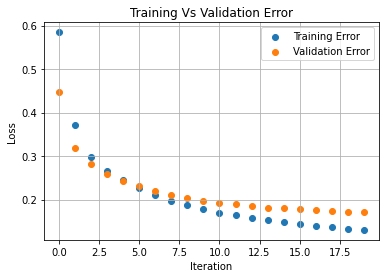

In [16]:
plt.scatter(x=history.epoch,y=history.history['loss'],label='Training Error')
plt.scatter(x=history.epoch,y=history.history['val_loss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

The continuous valued predictions coming from our model tend to skew toward 0 or 1, but there is sufficient mass between 0.1 and 0.9 that adjusting the cutoff should indeed shift a number of customers' predictions.  For example...

In [17]:
# Predicts a binary outcome for each observation
result = model.predict(X_test)

16/16 [==============================] - 0s 1ms/step


In [18]:
result[:10]

array([[2.0146215e-02],
       [9.9506158e-01],
       [2.6729283e-05],
       [7.8624362e-05],
       [4.7132254e-01],
       [9.9655545e-01],
       [9.9997997e-01],
       [9.2409486e-01],
       [9.9372572e-01],
       [9.9750191e-01]], dtype=float32)

In [23]:
column_list_file = '../data/churn/column_list.txt'
test_file = '../data/churn/test.csv'

In [24]:
columns = ''
with open(column_list_file,'r') as f:
    columns = f.read().split(',')

In [25]:
df_test = pd.read_csv(test_file,names=columns)

In [26]:
df_test['predicted_prob'] = result

In [27]:
df_test['predicted_class'] = np.where(result > 0.5,1,0)

In [28]:
df_test[['Churn?','predicted_class', 'predicted_prob']].head(10)

,Churn?,predicted_class,predicted_prob
0,0,0,0.020146
1,1,1,0.995062
2,0,0,0.000027
3,0,0,0.000079
4,1,0,0.471323
5,1,1,0.996555
6,1,1,0.999980
7,1,1,0.924095
8,1,1,0.993726
9,1,1,0.997502


## Binary Classifier Metrics

In [29]:
# Reference: https://scikit-learn.org/stable/modules/model_evaluation.html
# Explicitly stating labels. Pass=1, Fail=0
def true_positive(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 0]

def true_negative(y_true, y_pred): 
    return confusion_matrix(y_true,y_pred,labels=[1,0])[1, 1]

def false_positive(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[1, 0]

def false_negative(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 1]

In [30]:
# Compute Binary Classifier Metrics
# Returns a dictionary {"MetricName":Value,...}

def binary_classifier_metrics(y_true, y_pred):
    metrics = {}

    # References: 
    #  https://docs.aws.amazon.com/machine-learning/latest/dg/binary-classification.html
    #  https://en.wikipedia.org/wiki/Confusion_matrix
    
    # Definition:
    # true positive = tp = how many samples were correctly classified as positive (count)
    # true negative = tn = how many samples were correctly classified as negative (count)
    # false positive = fp = how many negative samples were mis-classified as positive (count)
    # false_negative = fn = how many positive samples were mis-classified as negative (count)
    
    # positive = number of positive samples (count)
    #          = true positive + false negative
    # negative = number of negative samples (count)
    #          = true negative + false positive
    
    tp = true_positive(y_true, y_pred)
    tn = true_negative(y_true, y_pred)
    fp = false_positive(y_true, y_pred)
    fn = false_negative(y_true, y_pred)
    
    positive = tp + fn
    negative = tn + fp
    
    metrics['TruePositive'] = tp
    metrics['TrueNegative'] = tn
    metrics['FalsePositive'] = fp
    metrics['FalseNegative'] = fn
    
    metrics['Positive'] = positive
    metrics['Negative'] = negative
    
    # True Positive Rate (TPR, Recall) = true positive/positive
    # How many positives were correctly classified? (fraction)
    # Recall value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        recall = 0
    else:
        recall = tp/positive
        
    metrics['Recall'] = recall
    
    # True Negative Rate = True Negative/negative
    # How many negatives were correctly classified? (fraction)
    # True Negative Rate value closer to 1 is better. closer to 0 is worse
    if tn == 0:
        tnr = 0
    else:
        tnr = tn/(negative)
    metrics['TrueNegativeRate'] = tnr
    
    # Precision = True Positive/(True Positive + False Positive)
    # How many positives classified by the algorithm are really positives? (fraction)
    # Precision value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        precision = 0
    else:
        precision = tp/(tp + fp)
    metrics['Precision'] = precision
    
    # Accuracy = (True Positive + True Negative)/(total positive + total negative)
    # How many positives and negatives were correctly classified? (fraction)
    # Accuracy value closer to 1 is better. closer to 0 is worse
    accuracy = (tp + tn)/(positive + negative)
    metrics['Accuracy'] = accuracy
    
    # False Positive Rate (FPR, False Alarm) = False Positive/(total negative)
    # How many negatives were mis-classified as positives (fraction)
    # False Positive Rate value closer to 0 is better. closer to 1 is worse
    if fp == 0:
        fpr = 0
    else:
        fpr = fp/(negative)
    metrics['FalsePositiveRate'] = fpr
    
    # False Negative Rate (FNR, Misses) = False Negative/(total Positive)
    # How many positives were mis-classified as negative (fraction)
    # False Negative Rate value closer to 0 is better. closer to 1 is worse
    fnr = fn/(positive)
    metrics['FalseNegativeRate'] = fnr
    
    # F1 Score = harmonic mean of Precision and Recall
    # F1 Score closer to 1 is better. Closer to 0 is worse.
    if precision == 0 or recall == 0:
        f1 = 0
    else:        
        f1 = 2*precision*recall/(precision+recall)

    metrics['F1'] = f1
    
    return metrics

In [31]:
# Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [32]:
# Compute confusion matrix
# 1 = customer left/churn, 0 = stayed
cnf_matrix = confusion_matrix(df_test['Churn?'], df_test['predicted_class'],labels=[1,0])

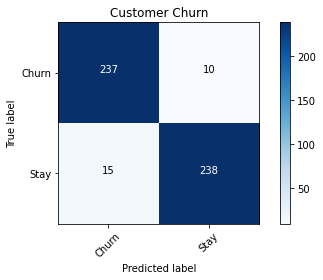

In [33]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=['Churn','Stay'],
                      title='Customer Churn')

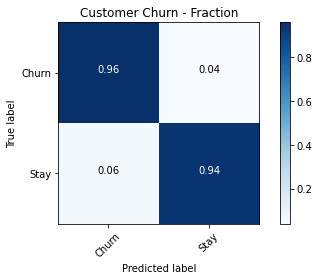

In [34]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churn','Stay'],
                      title='Customer Churn - Fraction', normalize=True)

In [35]:
metrics = [binary_classifier_metrics(df_test['Churn?'], df_test['predicted_class'])]
df_metrics=pd.DataFrame.from_dict(metrics)
df_metrics.index = ['Model']

In [36]:
df_metrics

,TruePositive,TrueNegative,FalsePositive,FalseNegative,Positive,Negative,Recall,TrueNegativeRate,Precision,Accuracy,FalsePositiveRate,FalseNegativeRate,F1
Model,237,238,15,10,247,253,0.959514,0.940711,0.940476,0.95,0.059289,0.040486,0.9499


In [37]:
print('Counts')
print(df_metrics[['TruePositive',
                  'FalseNegative',
                  'FalsePositive',
                  'TrueNegative',]].round(2))
print()
print('Fractions')
print(df_metrics[['Recall',
                  'FalseNegativeRate',
                  'FalsePositiveRate',
                  'TrueNegativeRate',]].round(2))
print()

print(df_metrics[['Precision',
                  'Accuracy',
                  'F1']].round(2))

Counts
       TruePositive  FalseNegative  FalsePositive  TrueNegative
Model           237             10             15           238

Fractions
       Recall  FalseNegativeRate  FalsePositiveRate  TrueNegativeRate
Model    0.96               0.04               0.06              0.94

       Precision  Accuracy    F1
Model       0.94      0.95  0.95


In [38]:
print(classification_report(df_test['Churn?'], df_test['predicted_class'],
                            labels=[1,0],
                            target_names=['Churn','Stay']))

              precision    recall  f1-score   support

       Churn       0.94      0.96      0.95       247
        Stay       0.96      0.94      0.95       253

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



In [39]:
df = df_test.sort_values('Churn?')
df = df.reset_index(drop=True)

In [40]:
df[['Churn?','predicted_class','predicted_prob']][:10]

,Churn?,predicted_class,predicted_prob
0,0,0,0.020146
1,0,1,0.660942
2,0,0,0.045794
3,0,0,0.029181
4,0,0,0.000552
5,0,0,0.002786
6,0,0,0.113437
7,0,1,0.723091
8,0,0,0.000419
9,0,0,0.349636


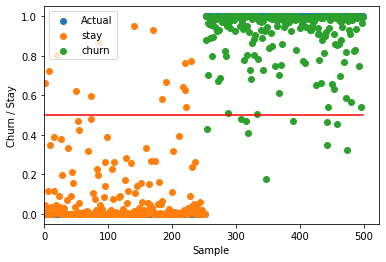

In [41]:
stay = df[df['Churn?']==0]
churn = df[df['Churn?']==1]

plt.figure()
plt.scatter(df.index,df['Churn?'],label='Actual')
plt.scatter(stay.index,stay['predicted_prob'],label='stay')
plt.scatter(churn.index,churn['predicted_prob'],label='churn')
plt.plot([df_test.index.min(),df_test.index.max()],[0.5,0.5],color='r')
plt.xlim(left=0)
plt.xlabel('Sample')
plt.ylabel('Churn / Stay')
plt.legend(loc=2)
plt.show()

1. Left side of plot has all "stay" samples - Majority of the samples are clustered near 0 (good) and only few are misclassified (above 0.5 threshold)
2. Right side of plot has all "churn" samples - Majority of the samples are above cutoff (good); however, few are misclassified (below 0.5 threshold)

In [42]:
# ROC AUC Score - Measure of how Recall and False Alarm change at different cutoff thresholds
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(df_test['Churn?'], df_test['predicted_prob'])
print('ROC AUC Score: {0:.3f}'.format(roc_score))

ROC AUC Score: 0.991


In [43]:
pd.crosstab(index=df_test['Churn?'], columns=np.where(df_test['predicted_prob'] > 0.5, 1, 0))

col_0,0,1
Churn?,,
0,238,15
1,10,237


We can see that changing the cutoff from 0.5 to 0.3 results in 1 more true positives, 3 more false positives, and 1 fewer false negatives.  The numbers are small overall here, but that's 6-10% of customers overall that are shifting because of a change to the cutoff.  Was this the right decision?  We may end up retaining 3 extra customers, but we also unnecessarily incentivized 5 more customers who would have stayed.  Determining optimal cutoffs is a key step in properly applying machine learning in a real-world setting.  Let's discuss this more broadly and then apply a specific, hypothetical solution for our current problem.

### Relative cost of errors

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with simple rules instead of ML.

More important, if I put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. I also need to look at similar costs associated with correct predictions of true positives and true negatives.  Because the choice of the cutoff affects all four of these statistics, I need to consider the relative costs to the business for each of these four outcomes for each prediction.

#### Assigning costs

What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of \$0. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this example, let's assume \$500. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of \$100. 

If my provider offered me such a concession, I’d certainly think twice before leaving. This is the cost of both true positive and false positive outcomes. 

In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will waste the \\$100 concession. We probably could have spent that \$100 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.

#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

```txt
$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs.  We test 100 possible values in the for loop below.

In [44]:
cutoffs = np.arange(0.1, .9, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * 
                               pd.crosstab(index=df_test['Churn?'],columns=np.where(df_test['predicted_prob'] > c, 1, 0)))))


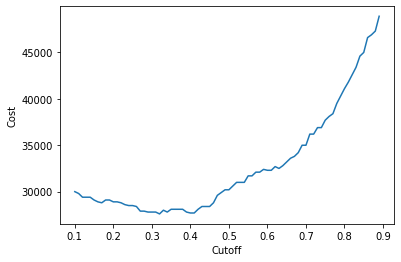

Cost is minimized near a cutoff of: 0.3199999999999999 for a cost of: 27600


In [45]:
costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.ylabel('Cost')
plt.xlabel('Cutoff')
plt.show()

print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

The above chart shows how picking a threshold too low results in costs skyrocketing as all customers are given a retention incentive.  Meanwhile, setting the threshold too high results in too many lost customers, which ultimately grows to be nearly as costly.  The overall cost can be minimized at \\$8400 by setting the cutoff to 0.46, which is substantially better than the \$20k+ I would expect to lose by not taking any action.

In [ ]:
stay = df[df['Churn?']==0]
churn = df[df['Churn?']==1]

plt.figure()
plt.scatter(df.index,df['Churn?'],label='Actual')
plt.scatter(stay.index,stay['predicted_prob'],label='stay')
plt.scatter(churn.index,churn['predicted_prob'],label='churn')
plt.plot([df_test.index.min(),df_test.index.max()],[cutoffs[np.argmin(costs)],cutoffs[np.argmin(costs)]],color='r')
plt.xlim(left=0)
plt.xlabel('Sample')
plt.ylabel('Churn / Stay')
plt.legend(loc=2)
plt.show()

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['Churn?'], np.where(df['predicted_prob'] > cutoffs[np.argmin(costs)], 1, 0),labels=[1,0])

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churn','Stay'],
                      title='Confusion Matrix at {0:0.2f}'.format(cutoffs[np.argmin(costs)]), normalize=True)


In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['Churn?'], np.where(df['predicted_prob'] > .5, 1, 0),labels=[1,0])

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Churn','Stay'],
                      title='Confusion Matrix at 0.5', normalize=True)

In [ ]:
# Improved recall and f1-score with lower cutoff
# However, precision has gone down
# So, cutoff threshold is a tradeoff based on problem at hand
print(classification_report(df['Churn?'], np.where(df['predicted_prob'] > cutoffs[np.argmin(costs)], 1, 0),
                            labels=[1,0],
                            target_names=['Churn','Stay']))

In [ ]:
print(classification_report(df['Churn?'], np.where(df['predicted_prob'] > 0.5, 1, 0),
                            labels=[1,0],
                            target_names=['Churn','Stay']))